# Metis Solar Wind Speed Calculator from UV and pB maps

This notebook implements the Doppler Dimming Technique (DDT) to evaluate Solar Wind Speed in the Solar Corona.

The ultraviolet (UV) and polarized Brightness ($pB$) maps are derived from the [Metis](https://metis.oato.inaf.it/index.html) coronagraph onboard the [Solar Orbiter](https://www.esa.int/Science_Exploration/Space_Science/Solar_Orbiter) spacecraft.

- Author: Dario Vetrano
- Date: August 2025
- Contact: dario.vetrano@studenti.polito.it

---

#### Notebook Initialization and Environment Setup

This section imports all necessary Python libraries, configures the computational environment, and loads the local modules containing the core scientific functions for the analysis.

In [2]:
# IMPORTING LIBRARIES
# =============================================================================
#  1. PYTHON STD LIBRARIES 
# =============================================================================
import os
import sys
import platform
import time
import warnings
from pathlib import Path
from datetime import datetime
from os.path import basename

# =============================================================================
#  2. SCIENTIFIC COMPUTING LIBRARIES
# =============================================================================
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16

import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter

from matplotlib import cm
from scipy.optimize import brentq, curve_fit, least_squares
from scipy.interpolate import interp1d
from scipy import ndimage

# =============================================================================
#  3. ASTRONOMY & ASTROPHYSICS LIBRARIES
# =============================================================================
import astropy.units as u
from astropy.io import fits
from astropy.wcs import FITSFixedWarning, WCS
from astropy.io.fits.verify import VerifyWarning
import sunpy.map
from sunpy.sun import constants

# --- CHIANTI Atomic Database Setup ---
# ChiantiPy requires the $XUVTOP environment variable to point to the database location.

# First, ensure the HOME variable is set, which is sometimes needed for Windows users
if 'HOME' not in os.environ and platform.system() == 'Windows':
    os.environ['HOME'] = os.path.expanduser('~')

# !!! IMPORTANT !!!
# You must replace the path below with the location of the CHIANTI database on your computer.
# xuvtop_path = r'C:\PATH\TO\YOUR\CHIANTI_11.0.2_database'
xuvtop_path = r'C:\Users\Lenovo1\Desktop\CORONA HYDRODYNAMIC STABILITY\Doppler Dimming Technique\codice\CHIANTI_DB\CHIANTI_11.0.2_database' 
os.environ['XUVTOP'] = xuvtop_path

import ChiantiPy.core as ch

# =============================================================================
#  4. JUPYTER NOTEBOOK & UTILITY LIBRARIES
# =============================================================================
from IPython.display import clear_output

# =============================================================================
#  5. LOCAL MODULES & CUSTOM FUNCTIONS
# =============================================================================
sys.path.append(str(Path().resolve().parent))

from src.aux_lib_lyman_alpha import compute_velocity_maps
from src.metis_aux_lib import calc_el_dens_and_K, polar_to_cart, align_polar_maps, fit_negative_power_series, cut_metis_fov, cart_to_polar, sqrt_model, extract_datetime_from_filename

# =============================================================================
#  6. ENVIRONMENT CONFIGURATION
# =============================================================================
# Suppress a common, often benign, warning from Astropy when reading FITS headers
warnings.filterwarnings('ignore', category=FITSFixedWarning)
warnings.simplefilter('ignore', category=VerifyWarning)

# =============================================================================
#  7. JUPYTER MAGIC COMMANDS
# =============================================================================
%reload_ext autoreload
%autoreload 2

#### Data Loading and Pre-processing

This section defines the paths to the observational data, loads the UV and VL FITS files, and matches them based on the closest acquisition time to create analysis-ready `sunpy` Map objects.

In [9]:
# ---------------- SETTINGS ----------------
folder_path_1 = Path(f'{str(Path().resolve().parent)}/data/input/UV_IMAGES')
folder_path_2 = Path(f'{str(Path().resolve().parent)}/data/input/VL_IMAGES')

# ---------------- LOAD FILE LISTS ----------------
L2_files_UV = [f for f in folder_path_1.iterdir() if f.is_file()]
L2_files_VL = [f for f in folder_path_2.iterdir() if f.is_file()]

# Parse dates
UV_with_dates = [(path, extract_datetime_from_filename(path.name)) for path in L2_files_UV]
VL_with_dates = [(path, extract_datetime_from_filename(path.name)) for path in L2_files_VL]

# ---------------- MATCHING ----------------
matches = []
for uv_path, uv_date in UV_with_dates:
    closest_vl_path, closest_vl_date = min(
        VL_with_dates,
        key=lambda x: abs((x[1] - uv_date).total_seconds())
    )
    matches.append((uv_path, closest_vl_path))

# ---------------- PROCESS EACH MATCH ----------------
for path_UV, path_VL in matches:

    print(f"\nProcessing:\nUV: {path_UV}\nVL: {path_VL}")

    fits_pb = fits.open(path_VL)[0]
    fits_uv = fits.open(path_UV)[0] 

    fits_pb.header['RSUN_OBS'] = fits_pb.header['RSUN_ARC']
    fits_uv.header['RSUN_OBS'] = fits_uv.header['RSUN_ARC']

    wcs_pb = WCS(fits_pb.header)
    wcs_uv = WCS(fits_uv.header)

    map_pb = sunpy.map.Map(fits_pb.data, fits_pb.header)
    map_uv = sunpy.map.Map(fits_uv.data, fits_uv.header)

    print("If nothing strange shows up (inf, nan, 0 ...), data has been correctly retrieved:",
        np.mean(fits_pb.data) / np.mean(fits_uv.data))

    cut_metis_fov(fits_pb)
    cut_metis_fov(fits_uv)

    METIS_VL_CMAP = plt.colormaps["plasma"].copy()
    METIS_VL_CMAP.set_bad(color='tab:gray') 

    METIS_UV_CMAP = plt.colormaps["RdYlBu_r"].copy()
    METIS_UV_CMAP.set_bad(color='tab:gray') 

    date_pb = fits_pb.header["DATE-OBS"]
    date_uv = fits_uv.header["DATE-OBS"]

    rsun_pix_uv = fits_uv.header['RSUN_ARC']/fits_uv.header['CDELT1'] 
    rsun_pix_pb = fits_pb.header['RSUN_ARC']/fits_pb.header['CDELT1'] 


    print(f"VL DATE-OBS: {date_pb} | UV DATE-OBS: {date_uv}")


Processing:
UV: C:\Users\Lenovo1\Desktop\CORONA HYDRODYNAMIC STABILITY\Doppler Dimming Technique\codice\DDT_branch_1\data\input\UV_IMAGES\solo_L2_metis-uv-image_20220915T223512_V01.fits
VL: C:\Users\Lenovo1\Desktop\CORONA HYDRODYNAMIC STABILITY\Doppler Dimming Technique\codice\DDT_branch_1\data\input\VL_IMAGES\solo_L2_metis-vl-pb_20220915T223500_V01.fits
If nothing strange shows up (inf, nan, 0 ...), data has been correctly retrieved: 5.1428937e-20
VL DATE-OBS: 2022-09-15T22:35:00.983 | UV DATE-OBS: 2022-09-15T22:35:12.253


#### Coordinate System Transformation

This section transforms the observational data from Cartesian (x, y) to polar (r, φ) coordinates. The `cart_to_polar` utility function is applied to both the UV and pB FITS data, creating new arrays where the data is organized radially. The resulting radial coordinates are then scaled from pixels to solar radii ($R_{\odot}$).

In [10]:
polar_uv, r_matrix_uv_pix, r_arr_uv, rsun_pix_uv, phi_arr_uv = cart_to_polar(fits_uv, dr = rsun_pix_uv / 100, dphi = 1, rot_angle=None, cval=np.nan, cut_out_fov = 50, cut_in_fov = 0)

polar_uv = np.where(polar_uv > 0, polar_uv, np.nan)

r_matrix_uv = r_matrix_uv_pix / rsun_pix_uv
r_arr_uv = r_arr_uv / rsun_pix_uv

polar_pb, r_matrix_pb_pix, r_arr_pb, rsun_pix_pb, phi_arr_pb = cart_to_polar(fits_pb, dr = rsun_pix_pb / 100, dphi = 1, cval=np.nan, cut_out_fov = 0, cut_in_fov = 5)

r_matrix_pb = r_matrix_pb_pix / rsun_pix_pb
r_arr_pb = r_arr_pb / rsun_pix_pb

#### Electron Density Inversion

This section derives the coronal electron density ($n_e$) map by applying the Van de Hulst inversion to the polar pB data. The resulting density map is then masked to preserve regions with no valid data from the original observations.

In [11]:
polar_ne, _ = calc_el_dens_and_K(polar_pb, r_arr_pb)

polar_ne = np.where(~np.isnan(polar_pb), polar_ne, np.nan)
polar_ne = np.where(polar_ne > 0, polar_ne, np.nan)


calc_binvertdata:
 - x = (3.660288723810256-7.503614891532754, dx=0.010)
 - k = [1, 2, 3, 4]
 - q = 0.63 


100%|██████████| 385/385 [00:06<00:00, 58.64it/s]


Done


#### Data Resampling and Alignment

This section resamples the UV and $n_e$ polar maps onto a common radial grid to ensure they are spatially aligned for subsequent analysis.

In [13]:
polar_uv_resam, polar_ne_resam, r_matrix, r_common = align_polar_maps(polar_uv, r_matrix_uv, r_arr_uv, polar_ne, r_matrix_pb, r_arr_pb)

--- Aligning Polar Maps ---
Original A shape: (147, 360), Original B shape: (385, 360)
Resampled A shape: (134, 360), Resampled B shape: (134, 360)
New common grid created with 134 radial steps from 3.66 R☉ to 5.00 R☉.
--- Alignment Complete ---


#### Data Visualization


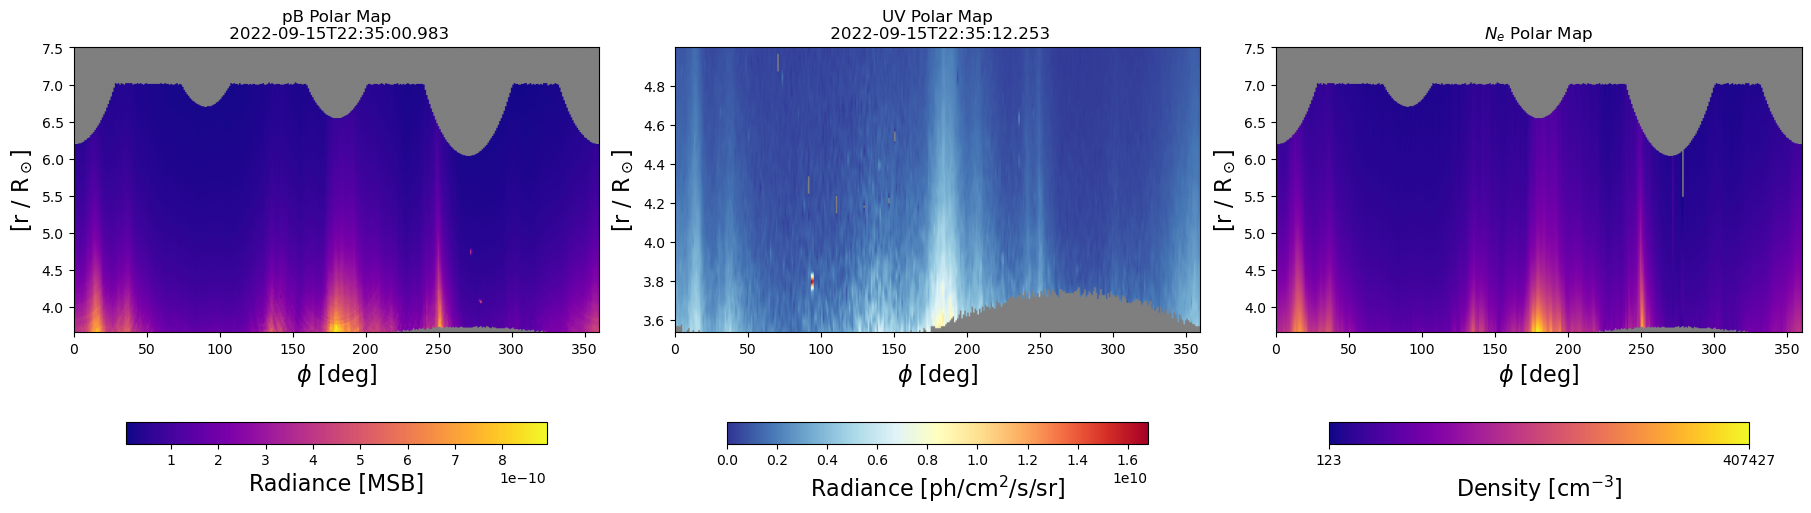

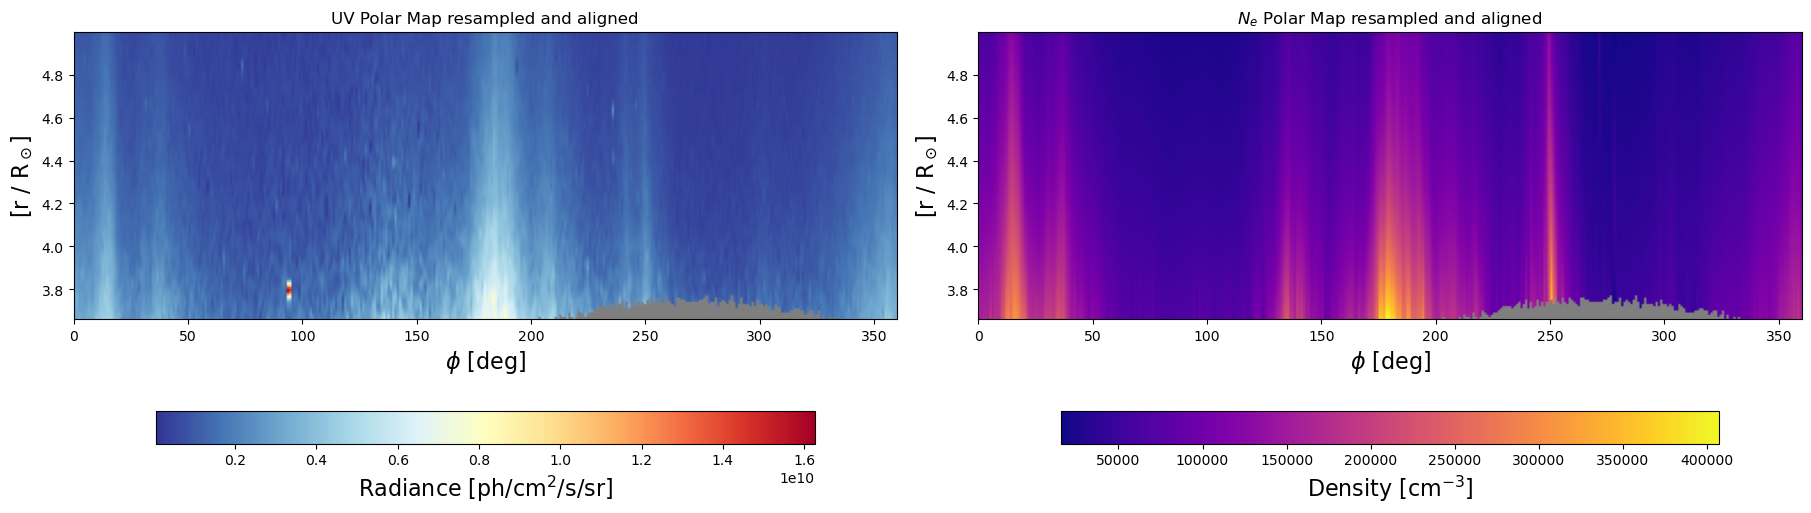

In [14]:
# PLOT

fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

# # Plot PB
im_pb = axes[0].imshow(polar_pb, cmap=METIS_VL_CMAP, origin="lower", extent=[0, polar_pb.shape[1], r_arr_pb[0], r_arr_pb[-1]], aspect = 'auto')
axes[0].set_title(f"pB Polar Map\n {date_pb}", fontsize=12)
cbar_pb = plt.colorbar(im_pb, ax=axes[0], orientation='horizontal', pad=0.1, shrink=0.8)
cbar_pb.set_label("Radiance [MSB]")
axes[0].set_ylabel("[r / R$_\\odot$]")
axes[0].set_xlabel("$\phi$ [deg]")

# Plot UV
im_uv = axes[1].imshow(polar_uv, cmap=METIS_UV_CMAP, origin="lower", extent=[0, polar_uv.shape[1], r_arr_uv[0], r_arr_uv[-1]], aspect = 'auto', vmin = 0)
axes[1].set_title(f"UV Polar Map\n {date_uv}", fontsize=12)
cbar_uv = plt.colorbar(im_uv, ax=axes[1], orientation='horizontal', pad=0.1, shrink=0.8)
cbar_uv.set_label("Radiance [ph/cm$^2$/s/sr]")
axes[1].set_ylabel("[r / R$_\\odot$]")
axes[1].set_xlabel("$\phi$ [deg]")

# Plot ne
im_ne = axes[2].imshow(polar_ne, cmap=METIS_VL_CMAP, origin="lower", extent=[0, polar_ne.shape[1], r_arr_pb[0], r_arr_pb[-1]], aspect = 'auto')
axes[2].set_title(f"$N_e$ Polar Map", fontsize=12)
cbar_ne = plt.colorbar(im_ne, ax=axes[2], orientation='horizontal', pad=0.1, shrink=0.8)
cbar_ne.set_label("Density [cm$^{-3}$]")
axes[2].set_ylabel("[r / R$_\\odot$]")
axes[2].set_xlabel("$\phi$ [deg]")

tick_positions = [np.nanmin(polar_ne), np.nanmax(polar_ne)] 
cbar_ne.set_ticks(tick_positions)

plt.show()


fig, axes = plt.subplots(1, 2, figsize=(18, 5), constrained_layout=True)

# Plot UV resampled and aligned
im_uv = axes[0].imshow(polar_uv_resam, cmap=METIS_UV_CMAP, origin="lower", extent=[0, polar_uv.shape[1], r_common[0], r_common[-1]], aspect = 'auto')
axes[0].set_title("UV Polar Map resampled and aligned", fontsize=12)
cbar_uv = plt.colorbar(im_uv, ax=axes[0], orientation='horizontal', pad=0.1, shrink=0.8)
cbar_uv.set_label("Radiance [ph/cm$^2$/s/sr]")
axes[0].set_ylabel("[r / R$_\\odot$]")
axes[0].set_xlabel("$\phi$ [deg]")

# Plot ne resampled and aligned
im_ne = axes[1].imshow(polar_ne_resam, cmap=METIS_VL_CMAP, origin="lower", extent=[0, polar_ne.shape[1], r_common[0], r_common[-1]], aspect = 'auto')
axes[1].set_title("$N_e$ Polar Map resampled and aligned", fontsize=12)
cbar_ne = plt.colorbar(im_ne, ax=axes[1], orientation='horizontal', pad=0.1, shrink=0.8)
cbar_ne.set_label("Density [cm$^{-3}$]")
axes[1].set_ylabel("[r / R$_\\odot$]")
axes[1].set_xlabel("$\phi$ [deg]")

plt.show()

### End of the preprocessing section
# Calculating the Solar Wind Velocity Map 
#### Step I: $V_w = $ const. along LOS
#### Step II: $V_w = f(x_{\text{LOS}})$
The core of the analysis is to determine the Solar Wind speed for each pixel in the pre-processed polar maps (UV and $N_e$): this is achieved through the definition of a resonant scattering model, and iteratively solving for the velocity that reproduces the observed UV intensity.

The algorithm iterates through every valid pixel, defined by its radius $r \in [\text{IN\_FOV}, \text{OUT\_FOV}]$ and polar angle $\phi \in [\phi_{\text{ROI,min}}, \phi_{\text{ROI,max}}]$.

In [ ]:
angle_ROI = np.r_[0:360]

velocity_map_kms_I, velocity_map_kms_II = compute_velocity_maps(
    polar_ne_resam=polar_ne_resam,
    polar_uv_resam=polar_uv_resam,
    r_matrix=r_matrix,
    angle_ROI=angle_ROI,
    save_matrix=True,
    date=str(date_pb + "_shift"),
    save_path = f'{str(Path().resolve().parent)}/data/output'
)

# velocity_map_kms_I = np.load(f'{str(Path().resolve().parent)}/data/output/vw_map_step_1_{date_pb.replace(':', '')}_shift.npy')
# velocity_map_kms_II = np.load(f'{str(Path().resolve().parent)}/data/output/vw_map_step_2_sqrt_{date_pb.replace(':', '')}_shift.npy')

Step II: angles: 100%|██████████| 360/360 [03:43<00:00,  1.61it/s]

Velocity maps saved.


#### Data Visualization

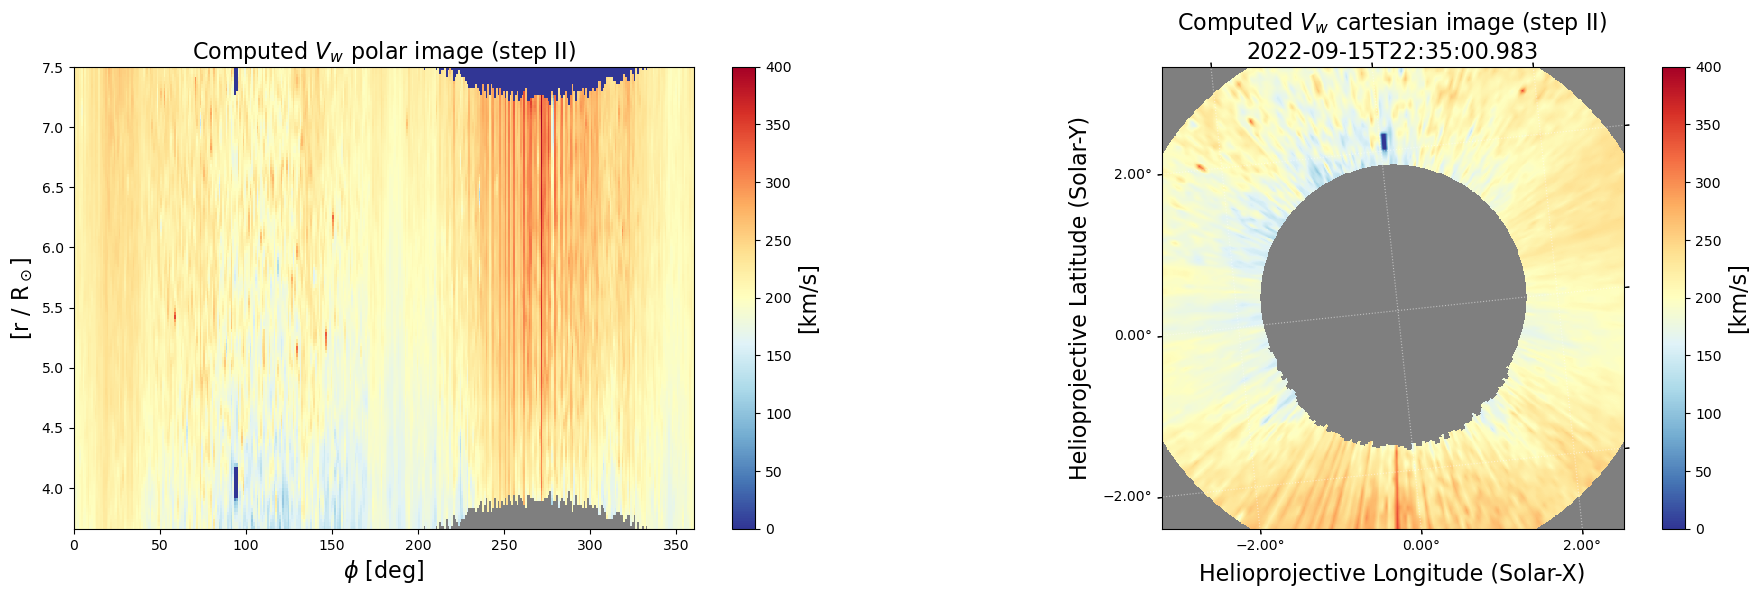

In [17]:
# PLOT
my_cartesian_Vw_II = polar_to_cart(velocity_map_kms_II, (512, 512), 256, 256, rsun_pix_pb, r_arr_pb[0], r_arr_pb[-1], 1 / rsun_pix_uv, rot_angle=None, cut_fov=True)

fig0 = plt.figure(figsize=(22, 6))

ax0 = fig0.add_subplot(1, 2, 1)  
img_Vw_pol0 = ax0.imshow(velocity_map_kms_II, origin='lower', cmap=METIS_UV_CMAP, interpolation='none',  vmin = 0, vmax = 400 , extent=[0, polar_ne.shape[1], r_arr_pb[0] , r_arr_pb[-1] ], aspect = 'auto')
ax0.set_ylabel("[r / R$_\\odot$]")
ax0.set_xlabel("$\phi$ [deg]");

my_cbar_Vw= plt.colorbar(img_Vw_pol0, ax=ax0, label='[km/s]')
ax0.set_title('Computed $V_w$ polar image (step II)');

ax1 = fig0.add_subplot(1, 2, 2, projection=wcs_pb)

img_Vw = ax1.imshow(my_cartesian_Vw_II, origin='lower', cmap=METIS_UV_CMAP,  vmin = 0, vmax = 400, interpolation='none')
cbar_Vw = plt.colorbar(img_Vw, ax=ax1, label='[km/s]')

lon, lat = ax1.coords
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
ax1.coords.grid(True, color = 'white', ls = 'dotted', alpha = 0.5)
ax1.set_xlabel('Helioprojective Longitude (Solar-X)')
ax1.set_ylabel('Helioprojective Latitude (Solar-Y)')
ax1.set_title('Computed $V_w$ cartesian image (step II) \n' + date_pb);

#### Visualization of selected radials

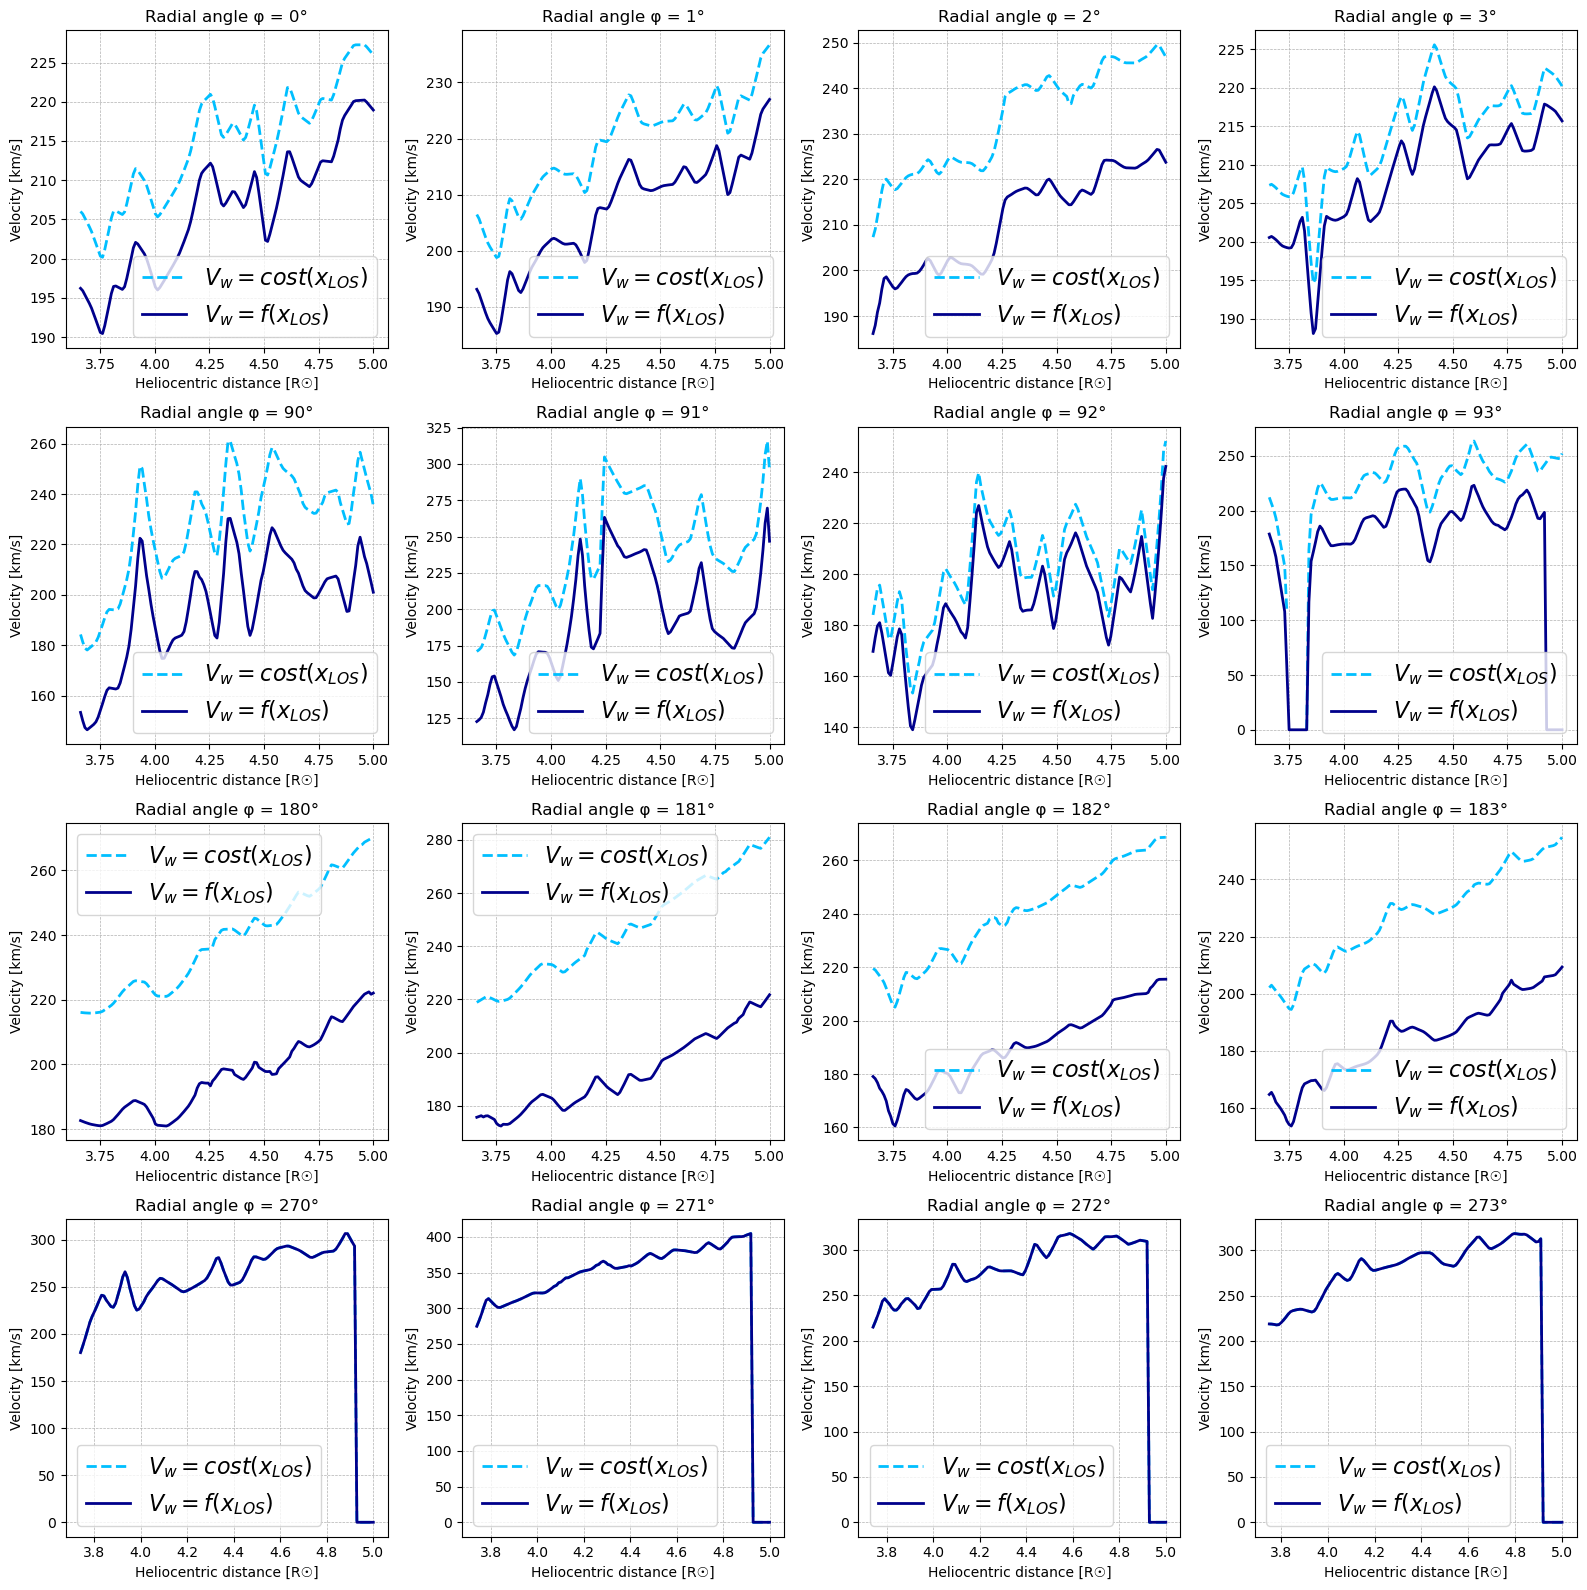

In [18]:
angle_ROI_plot = np.r_[0:4, 90:94, 180:184, 270:274]  

ncols = 4
nrows = round(np.ceil(len(angle_ROI_plot) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
axes = axes.flatten()

for ax, phi_select in zip(axes, angle_ROI_plot):
    r_radial = r_matrix[:, phi_select]
    v_radial_I = velocity_map_kms_I[:, phi_select]
    v_radial_II = velocity_map_kms_II[:, phi_select]
    
    ax.plot(r_radial, v_radial_I, color='deepskyblue', linestyle = '--', linewidth=2)
    ax.plot(r_radial, v_radial_II, color='darkblue', linewidth=2)
    
    ax.set_title(f"Radial angle φ = {phi_select}°", fontsize=12)
    
    ax.set_ylabel("Velocity [km/s]", fontsize=10)
    ax.set_xlabel("Heliocentric distance [R☉]", fontsize=10)

    
    ax.grid(True, which="both", linestyle='--', linewidth=0.5)
    ax.legend(["$V_w = cost(x_{LOS})$", "$V_w = f(x_{LOS})$"])

# Hide the last empty subplot (if any)
for ax in axes[len(angle_ROI_plot):]:
    ax.set_visible(False)

plt.tight_layout()

# plt.savefig('radial_cfr_btw_maps.png')
plt.show()